# Advanced Lane Line Finding

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import pickle
import os.path
from collections import deque
from tqdm import tqdm

%matplotlib inline
class Line():
    """class to receive the characteristics of each line detection"""
    def __init__(self, frames_to_keep=5):
        self.recent_nx = deque([], frames_to_keep)
        self.recent_nfits = deque([], frames_to_keep)
        self.recent_curvrad = deque([], frames_to_keep)
        self.recent_x_pos = deque([], frames_to_keep)
        self.last_found = False
    
    def found_fits(self):
        return [f for f in self.recent_nfits if f is not None]
    
    def best_fit(self):
        """Returns the best fit according to the last n fits"""
        found_fits = self.found_fits()
        if not found_fits:
            return None
        else:
            average_fit = np.mean(found_fits, axis=0)
            return average_fit
        
    def best_x(self):
        found_x_pos = [x for x in self.recent_x_pos if x is not None]
        return np.mean(found_x_pos)
        
    def line_valid(self, line_fit):
        curvrad = self.curvature_radius(line_fit)
        xpos = self.calc_x_pos(line_fit)
        best_x = self.best_x()
        
        if curvrad < 350.0:
            return False
        if best_x and abs(xpos - best_x) > 70:
            return False
        return True
        
    def append_fit(self, line_fit):
        # Sanity check
        if not self.line_valid(line_fit):
            if self.last_found:
                self.recent_nfits.append(None)
                self.last_found = False
        else:
            self.last_found = True
            self.recent_nfits.append(line_fit)
            self.recent_x_pos.append(self.calc_x_pos(line_fit))

    
    def recent_fit(self):
        found_fits = self.found_fits()
        return self.recent_nfits[-1] if fount_fits else None
    
    def curvature_radius(self, line_fit):
        """Calculate the curvature of fit line"""
        ym_per_pix = 30/720
        xm_per_pix = 3.7/700
        # refit line in world space
        ploty = np.array([100, 200, 300, 400, 500])
        # ploty = np.linspace(0, self.height-1, self.height)
        plotx = line_fit[0]*ploty**2 + line_fit[1]*ploty + line_fit[2]
        fit_cr = np.polyfit(ploty*ym_per_pix, plotx*xm_per_pix, 2)
        
        y_eval = 720*ym_per_pix
        curvrad = ((1 + (2*fit_cr[0]*y_eval + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])
        return curvrad
    
    def calc_x_pos(self, line_fit):
        """Gets the bottom line pixel x coordinate"""
        y_eval = 720
        return np.int(line_fit[0]*y_eval**2 + line_fit[1]*y_eval + line_fit[2])

class LaneFinder():
    """Finds laneline inside car camera images"""
    def __init__(self):
        self.width = 1280
        self.height = 720
        self.left_lines = Line()
        self.right_lines = Line()
        
    def calibrate_camera(self, force=False):
        """Calculate the camera distortion matrix"""
        # camera distortion matrix pickle file
        dist_mtx_file = 'distort_mtx.p'
        # calibration images glob
        chessboard_images = './camera_cal/*.jpg'
                
        if os.path.isfile(dist_mtx_file) and not force:
            # load camera distortion matrix if already exists
            dist_pickle = pickle.load(open(dist_mtx_file, 'rb'))
            self.camera = {
                'mtx': dist_pickle['mtx'],
                'dist': dist_pickle['dist'],
            }
        else:
            # Start calibrating camera
            # prepare object points
            nx, ny = 9, 5
            objp = np.zeros((nx*ny, 3), np.float32)
            objp[:, :2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)
            objpoints = []  # 3D coord in real world
            imgpoints = []  # 2D coord in image plane

            calibration_img_paths = glob.glob(chessboard_images)
            # use tqdm to display progress bar
            for img_path in tqdm(calibration_img_paths):
                img = cv2.imread(img_path)
                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
                if ret == True:
                    objpoints.append(objp)
                    imgpoints.append(corners)

            ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(
                objpoints, imgpoints, img_size, None, None)

            # Save the camera calibration result for later use
            self.camera = {
                'mtx': mtx,
                'dist': dist,
            }
            # Save camera matrix to avoid recalibrating every time
            # run with force=True to force recalibrate
            pickle.dump(self.camera, open(dist_mtx_file, 'wb'))

    def undistort(self, img):
        """Undistort image using camera matrix"""
        assert 'mtx' in self.camera
        assert 'dist' in self.camera
        mtx = self.camera['mtx']
        dist = self.camera['dist']
        undist = cv2.undistort(img, mtx, dist, None, mtx)
        return undist

    def s_magnitude(self, img, thresh=(175, 255)):
        """Returns magnitude thresholded binary image of 
        the S channel in HLS color space
        """
        hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
        s_channel = hls[:,:,2]
        magnitude_binary = np.zeros_like(s_channel)
        magnitude_binary[(s_channel >= thresh[0]) & (s_channel <= thresh[1])] = 1
        return magnitude_binary 
        
    def l_direction(self, img, sobel_kernel=7, m_thresh=(14, 255), d_thresh=(0.0, 0.73)):
        """Returns the sobel magnitude and direction thresholded
        binary image of the L channel in HLS color space
        """
        hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
        l_channel = hls[:,:,1]

        sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
        sobely = cv2.Sobel(l_channel, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
        magnitude = np.sqrt(np.square(sobelx)+np.square(sobely))
        scaled = np.uint8(255*magnitude/np.max(magnitude))
        abs_sobelx = np.absolute(sobelx)
        abs_sobely = np.absolute(sobely)
        direction = np.arctan2(abs_sobely, abs_sobelx)
        binary_output = np.zeros_like(direction)
        binary_output[
            (direction >= d_thresh[0])&(direction <= d_thresh[1])&
            (scaled >= m_thresh[0])&(scaled <= m_thresh[1])] = 1
        return binary_output
    
    def combined_thresholding(self, img):
        """Returns the combined result of all thresholdings"""
        s_mag = self.s_magnitude(img)
        l_dir = self.l_direction(img)
        combined_binary = np.zeros_like(img[:,:,1])
        combined_binary[(s_mag == 1) | (l_dir == 1)] = 1
        return combined_binary 
    
    def get_perspective_transform_matrix(self, reverse=False):
        tls = (563, 470)  # top left source point
        bls = (220, 700)  # bottom left source point
        tld = (300, 300)  # top left destination 
        bld = (300, 720)  # bottom left destination
        
        src = np.float32([
            [tls[0], tls[1]],
            [self.width-tls[0], tls[1]],
            [self.width-bls[0], bls[1]],
            [bls[0], bls[1]]
        ])

        dst = np.float32([
            [tld[0], tld[1]],
            [self.width-tld[0], tld[1]],
            [self.width-tld[0], bld[1]],
            [bld[0], bld[1]],
        ])
        
        if reverse:
            transform_mtx = cv2.getPerspectiveTransform(dst, src)
        else:
            transform_mtx = cv2.getPerspectiveTransform(src, dst)
        return transform_mtx
    
    def perspective_transform(self, img, reverse=False):
        """Transform car camera image into birds eye view"""
        transform_mtx = self.get_perspective_transform_matrix(reverse=reverse)
        shape = (self.width, self.height)
        warped = cv2.warpPerspective(
            img, transform_mtx, shape, flags=cv2.INTER_LINEAR)
        return warped
    
    def histogram_find_lines(self, binary_warped, visualize=False):
        """Find left/right lane line indices from the binary warped 
        image without knowing previous line positions using the
        hostogram/sliding window method
        """
        width, height = self.width, self.height
        nwindows = 9
        window_height = np.int(height/nwindows)

        histogram = np.sum(binary_warped[int(height/2):,:], axis=0)
        midpoint = np.int(width/2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        leftx_current = leftx_base
        rightx_current = rightx_base

        left_lane_inds = []
        right_lane_inds = []
        windows = []  # record search window for visualization

        margin = 100  # half window size
        minpix = 100   # least pixels to be recognized as found

        for window in range(nwindows):
            win_y_low = height - (window+1)*window_height
            win_y_high = height - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            
            windows.append((win_xleft_low, win_y_low, win_xleft_high, win_y_high))
            windows.append((win_xright_low, win_y_low, win_xright_high, win_y_high))
            
            good_left_inds = (
                (nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = (
                (nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)

            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds]
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        
        out_img = None
        if visualize:
            # color left/right lines
            out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
            out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
            out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
            # draw window
            for rect in windows:
                tlx, tly, brx, bry = rect
                cv2.rectangle(out_img, (tlx, tly), (brx, bry), (0, 255, 0), 2)
        
        return left_fit, right_fit, out_img
    
    def convolution_find_lines(self, binary_warped, left_fit, right_fit, visualize=False):
        """Find line around known previous lines"""
        window_width = 50
        hww = 25  # half window width
        n_windows = 9
        window_height = self.height/n_windows
        window_centroids = []
        margin = 100  # How much to slide left/right for searching
        window = np.ones(window_width)
        offset = np.int((window_width + margin)/2)

        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        left_lane_inds = []
        right_lane_inds = []
        
        for level in range(n_windows):
            y_min = np.int(level*window_height)
            y_max = np.int(y_min + window_height)
            layer = binary_warped[y_min:y_max,:]
            image_layer = np.sum(layer, axis=0)
            conv_signal = np.convolve(window, image_layer)
            
            y_eval = (y_min + y_max)/2
            l_base = np.int(left_fit[0]*y_eval**2 + left_fit[1]*y_eval + left_fit[2])
            l_base = max(0, min(self.width, l_base))
            l_center = np.argmax(
                conv_signal[max(0, l_base-offset): min(self.width,l_base+offset)]) + l_base - offset - hww
            r_base = np.int(right_fit[0]*y_eval**2 + right_fit[1]*y_eval + right_fit[2])
            r_base = max(0, min(self.width, r_base))
            r_center = np.argmax(
                conv_signal[max(0, r_base-offset): min(self.width, r_base+offset)]) + r_base - offset - hww
            window_centroids.append((l_center, r_center))
            good_left_inds = (
                (nonzeroy >= y_min) & (nonzeroy <= y_max) & 
                (nonzerox >= (l_center-hww)) & (nonzerox <= (l_center+hww))).nonzero()[0]
            good_right_inds = (
                (nonzeroy >= y_min) & (nonzeroy <= y_max) &
                (nonzerox >= (r_center-hww)) & (nonzerox <= (r_center+hww))).nonzero()[0]
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)

        
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
        
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds]
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        
        out_img = None
        if visualize:
            # color left/right lines
            out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
            out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
            out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
            
            for level, (l_center, r_center) in enumerate(window_centroids):
                tlx, tly, brx, bry = l_center-hww ,level*80, l_center+hww, (level+1)*80 
                cv2.rectangle(out_img, (tlx, tly), (brx, bry), (0, 255, 0), 2)

                tlx, tly, brx, bry = r_center-hww ,level*80, r_center+hww, (level+1)*80 
                cv2.rectangle(out_img, (tlx, tly), (brx, bry), (0, 255, 0), 2)
                
                
        return left_fit, right_fit, out_img
    
    def find_lines(self, img):
        """Find lane line"""
        prev_left_fit = self.left_lines.best_fit()
        prev_right_fit = self.right_lines.best_fit()
        if prev_left_fit is None or prev_right_fit is None:
            naive_left_fit, naive_right_fit, _ = self.histogram_find_lines(img)
            prev_left_fit = naive_left_fit if prev_left_fit is None else prev_left_fit
            prev_right_fit = naive_right_fit if prev_right_fit is None else prev_right_fit
        
        new_left_fit, new_right_fit, _ = self.convolution_find_lines(img, prev_left_fit, prev_right_fit)
        
        # TODO(Olala): sanity check before append
        self.left_lines.append_fit(new_left_fit)
        self.right_lines.append_fit(new_right_fit)
        avg_left_fit = self.left_lines.best_fit()
        avg_right_fit = self.right_lines.best_fit()
        assert avg_left_fit is not None
        assert avg_right_fit is not None
        return avg_left_fit, avg_right_fit

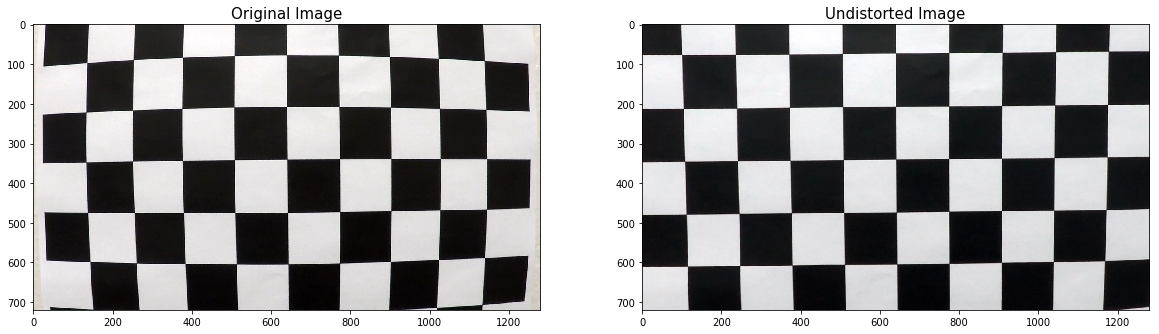

In [4]:
# Test LaneFinder calibration and undistort method
lf = LaneFinder()
lf.calibrate_camera()
img = cv2.imread('./camera_cal/calibration1.jpg')
rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
undist = lf.undistort(img)

# visualize and save undistorted image
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(rgb)
ax1.set_title('Original Image', fontsize=15)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=15)
plt.imsave('./output_images/chessboard_original.jpg', rgb)
plt.imsave('./output_images/chessboard_undistort.jpg', undist)


/Users/hsin-cheng/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/hsin-cheng/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


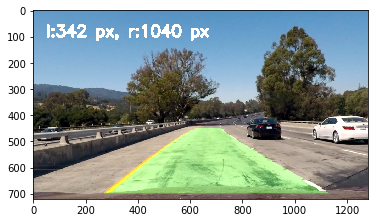

In [9]:
# Defind and test image pipeline
# First make sure we initiate and calibrate the LandFinder class
lf = LaneFinder()
lf.calibrate_camera()

def img_pipeline(img, visualize=False):
    undist = lf.undistort(img)
    warped = lf.perspective_transform(undist)
    combined_binary = lf.combined_thresholding(warped)
    left_fit, right_fit = lf.find_lines(combined_binary)
    result = np.dstack((combined_binary, combined_binary, combined_binary))*255

    ploty = np.linspace(0, lf.height-1, lf.height)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    cp = np.zeros_like(result)
    cv2.fillPoly(cp, np.int_([pts]), (0,255, 0))
    # display warped
#     result = cv2.addWeighted(result, 1.0, cp, 0.5, 0)
    # dispart unwarped
    road = lf.perspective_transform(cp, reverse=True)
    result = cv2.addWeighted(undist, 1.0, road, 0.3, 0)

    # write info on result
    left_lines = lf.left_lines
    right_lines = lf.right_lines
    left_x = left_lines.best_x()
    right_x = right_lines.best_x()
    
    result = cv2.putText(
        result, 'l:%d px, r:%d px' % (left_x, right_x), 
        (50, 100), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255), 10)
    
    if visualize:
        cv2.imwrite('output_images/pipeline_in.jpg', img)
        cv2.imwrite('output_images/pipeline_undist.jpg', undist)

        
    return result

img = cv2.imread('./test_images/test1.jpg')
result = img_pipeline(img, visualize=True)
result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
plt.imshow(result)


In [ ]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# run image pipeline with video
outfile = 'results.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(img_pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(outfile, audio=False)

In [ ]:
# Test LaneFinder find_lines

test_images = [
    './test_images/straight_lines1.jpg',
    './test_images/straight_lines2.jpg',
    './test_images/test1.jpg',
    './test_images/test2.jpg',
    './test_images/test3.jpg',
    './test_images/test4.jpg',
    './test_images/test5.jpg',
    './test_images/test6.jpg',
    'strange.jpg',
]

f, axarr = plt.subplots(len(test_images), 2, figsize=(20, 5*len(test_images)))
for idx, img_path in enumerate(test_images):
    lf = LaneFinder()
    lf.calibrate_camera()

    img = cv2.imread(img_path)
    undist = lf.undistort(img)
    warped = lf.perspective_transform(undist)
    combined_binary = lf.combined_thresholding(warped)
    n_left_fit, n_right_fit, out_img = lf.histogram_find_lines(combined_binary, visualize=False)
    left_fit, right_fit, out_img = lf.convolution_find_lines(combined_binary, n_left_fit, n_right_fit, visualize=True)
    
    rgb_warped = cv2.cvtColor(warped, cv2.COLOR_BGR2RGB)
    axarr[idx][0].imshow(rgb_warped)
    
    # plot naive_find_lines line
    ploty = np.linspace(0, lf.height-1, lf.height)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    axarr[idx][1].imshow(out_img, cmap='gray')
    axarr[idx][1].plot(left_fitx, ploty, color='yellow')
    axarr[idx][1].plot(right_fitx, ploty, color='yellow')
    axarr[idx][1].set_xlim([0, 1280])
    axarr[idx][1].set_ylim([720, 0])
    
#     left_fit, right_fit = lf.find_lines(combined_binary)
#     left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
#     right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
#     axarr[idx][2].imshow(combined_binary, cmap='gray')
#     axarr[idx][2].plot(left_fitx, ploty, color='red')
#     axarr[idx][2].plot(right_fitx, ploty, color='blue')
#     axarr[idx][2].set_xlim([0, 1280])
#     axarr[idx][2].set_ylim([720, 0])
    

output_images/orig_1.jpg output_images/warped_1.jpg
output_images/orig_2.jpg output_images/warped_2.jpg
output_images/orig_3.jpg output_images/warped_3.jpg
output_images/orig_4.jpg output_images/warped_4.jpg
output_images/orig_5.jpg output_images/warped_5.jpg
output_images/orig_6.jpg output_images/warped_6.jpg
output_images/orig_7.jpg output_images/warped_7.jpg
output_images/orig_8.jpg output_images/warped_8.jpg


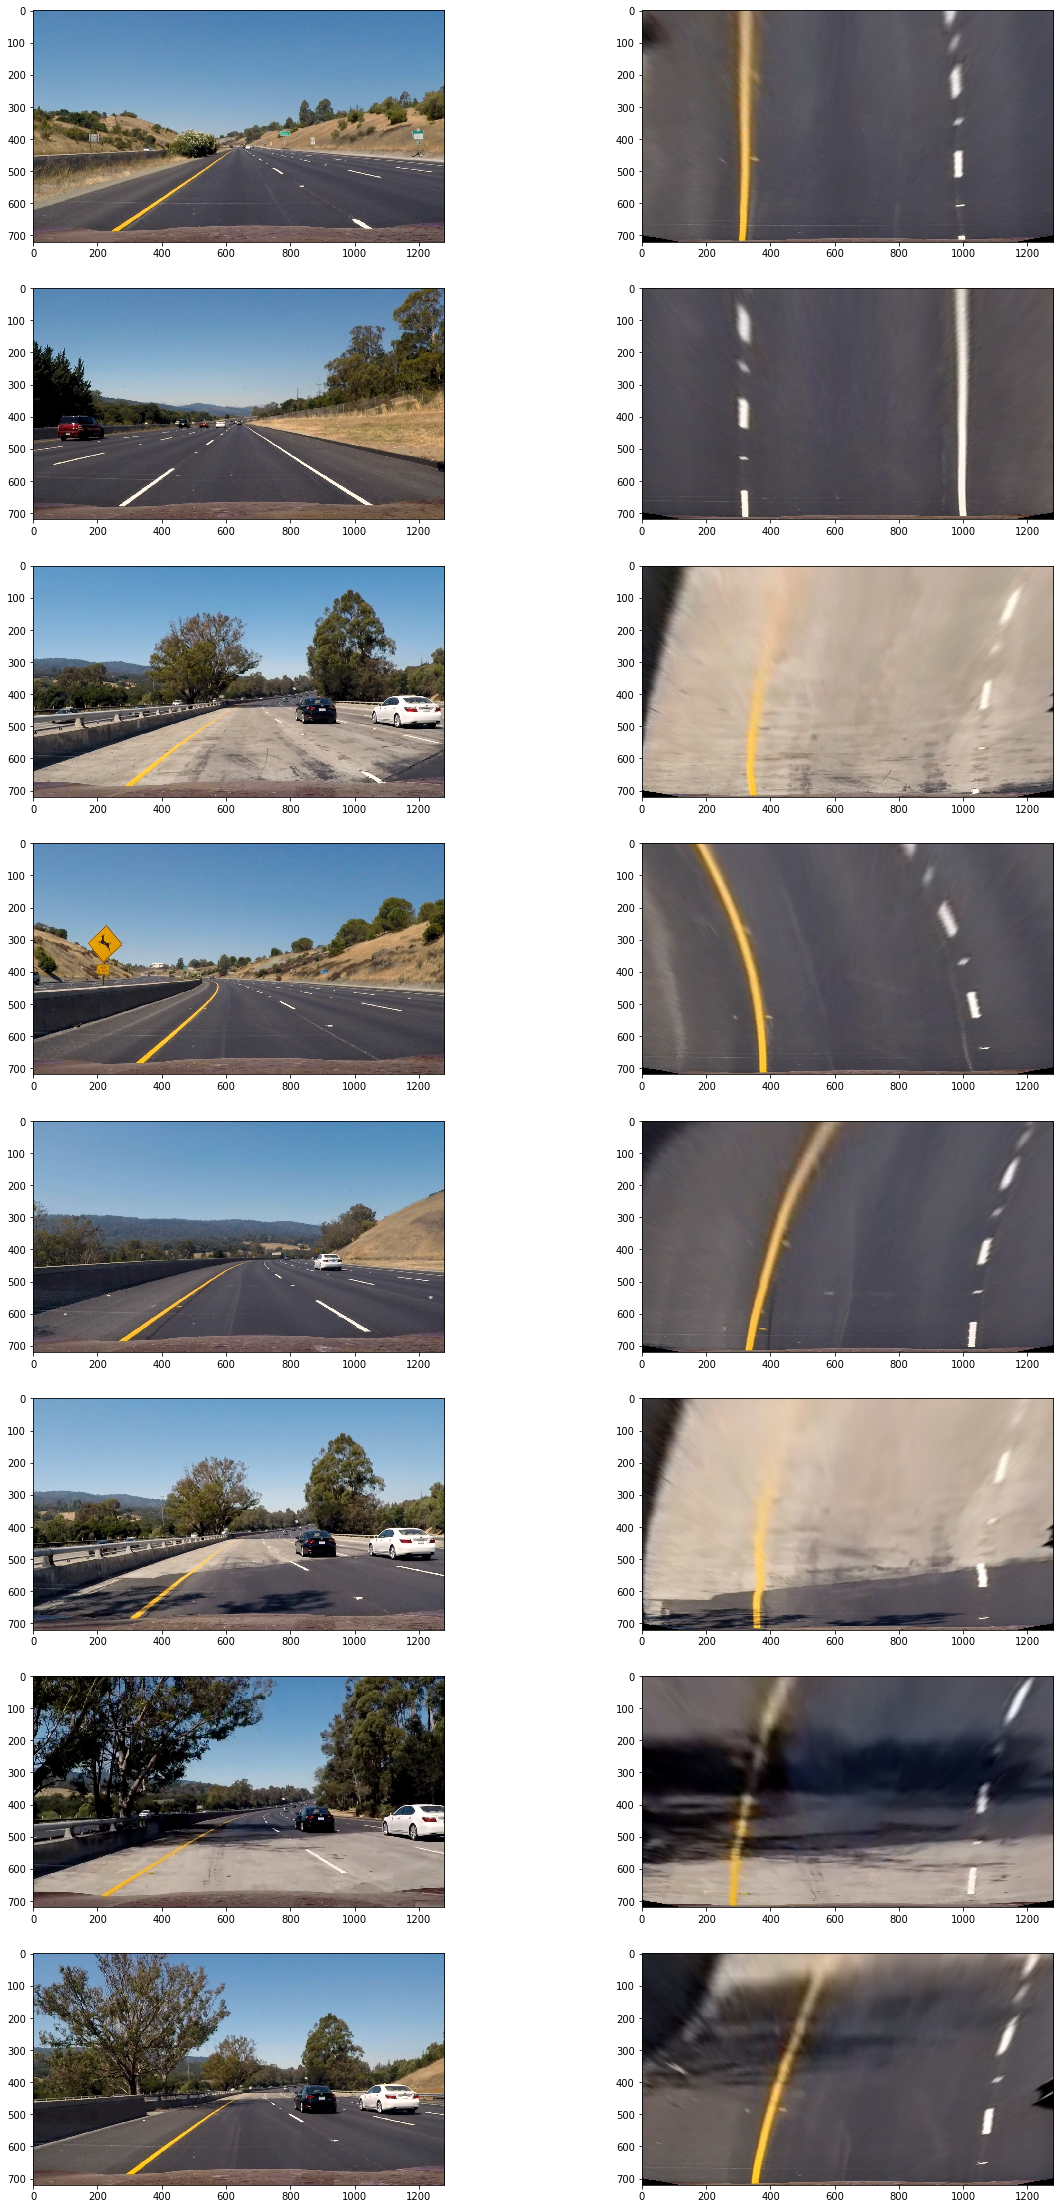

In [25]:
# Test LaneFinder perspective transform
lf = LaneFinder()
lf.calibrate_camera()
test_images = [
    './test_images/straight_lines1.jpg',
    './test_images/straight_lines2.jpg',
    './test_images/test1.jpg',
    './test_images/test2.jpg',
    './test_images/test3.jpg',
    './test_images/test4.jpg',
    './test_images/test5.jpg',
    './test_images/test6.jpg',
]

f, axarr = plt.subplots(len(test_images), 2, figsize=(20, 5*len(test_images)))
for idx, img_path in enumerate(test_images):
    img = cv2.imread(img_path)
    undist = lf.undistort(img)
    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    warped = lf.perspective_transform(rgb)
    axarr[idx][0].imshow(rgb)
    axarr[idx][1].imshow(warped)
    
    orig_name = 'output_images/orig_%d.jpg' % (idx + 1)
    warped_name = 'output_images/warped_%d.jpg' % (idx + 1)
    print(orig_name, warped_name)
    cv2.imwrite(orig_name, img)
    cv2.imwrite(warped_name, warped)    

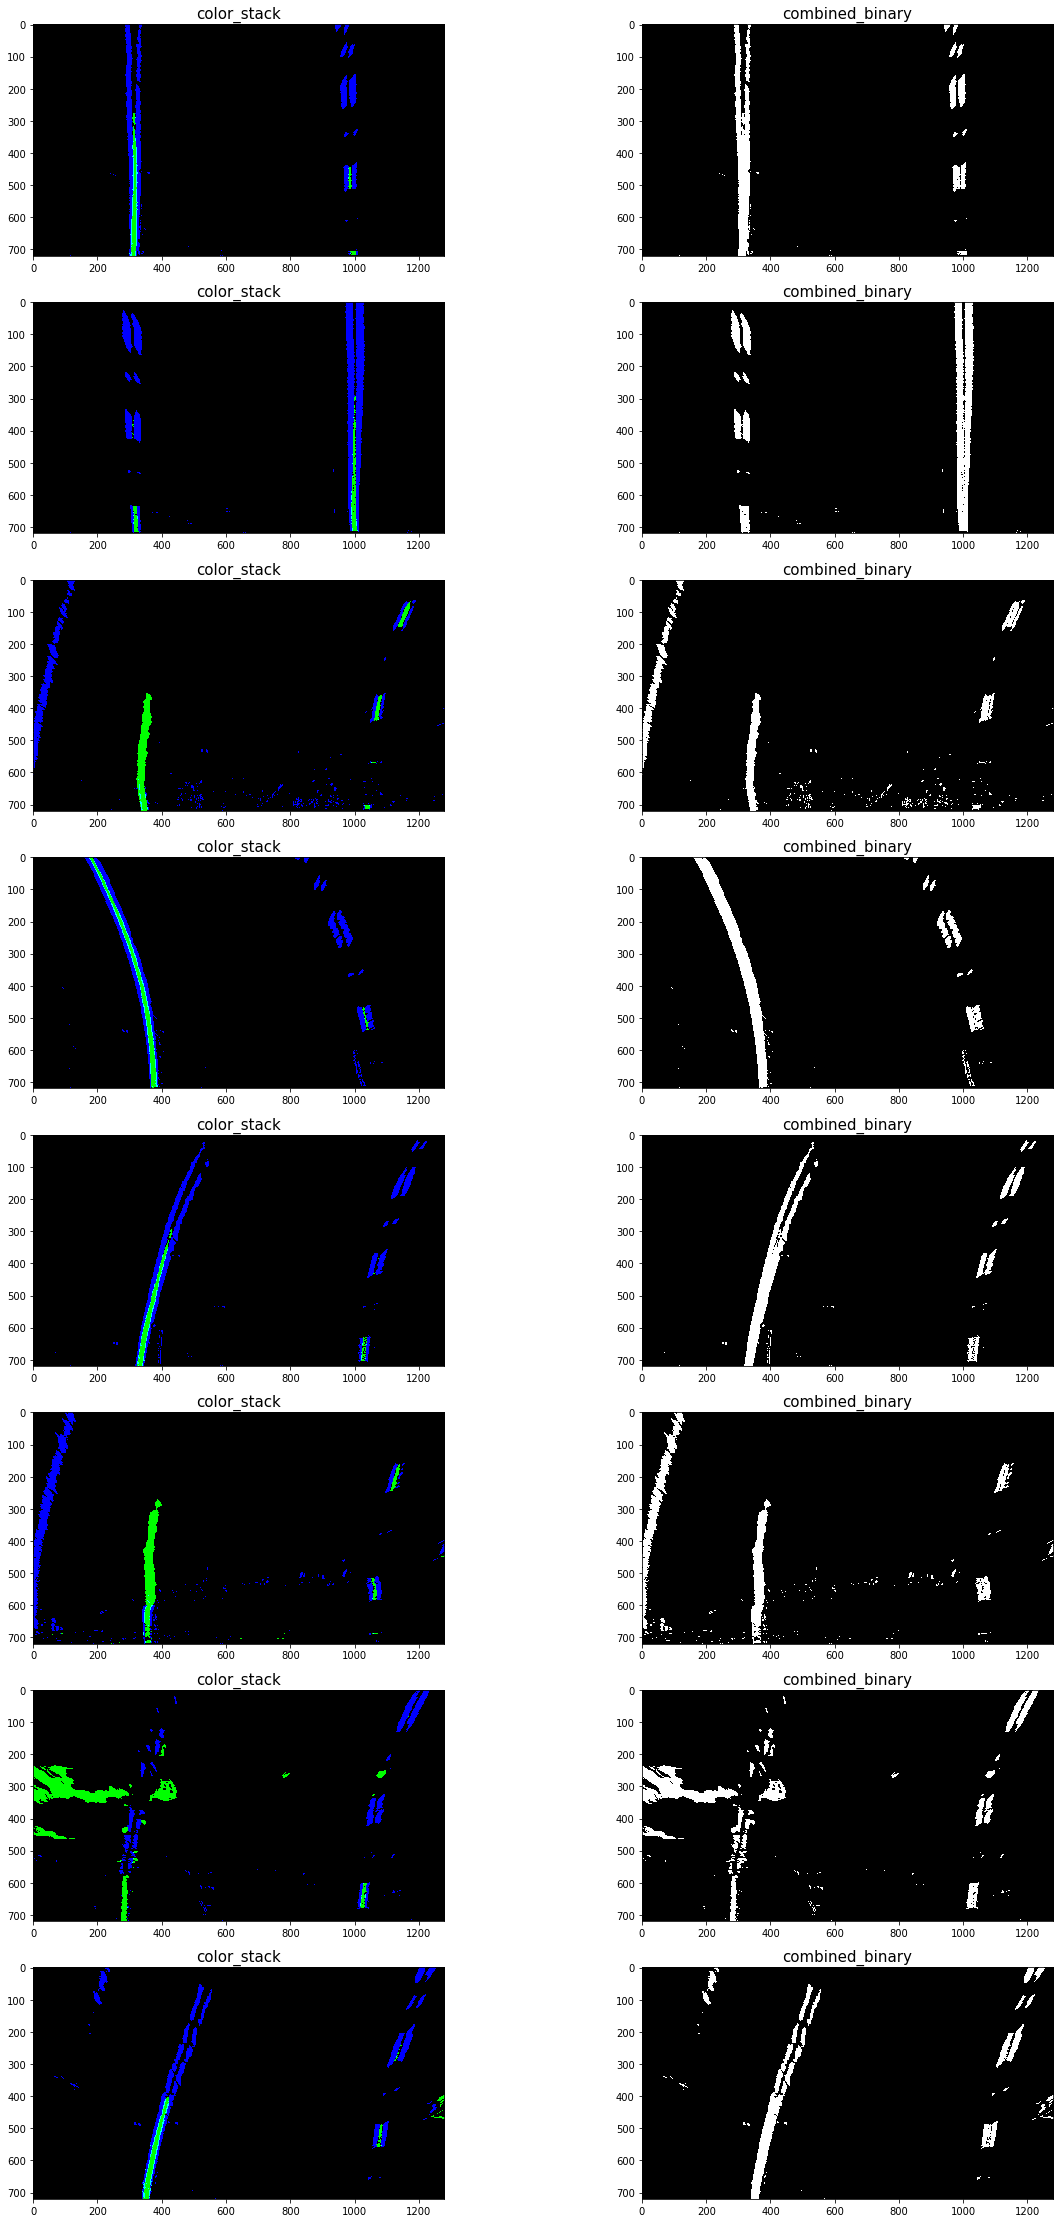

In [16]:
# Tesh LaneFilder thresholding methods
lf = LaneFinder()
lf.calibrate_camera()
test_images = [
    './test_images/straight_lines1.jpg',
    './test_images/straight_lines2.jpg',
    './test_images/test1.jpg',
    './test_images/test2.jpg',
    './test_images/test3.jpg',
    './test_images/test4.jpg',
    './test_images/test5.jpg',
    './test_images/test6.jpg',
]


f, axarr = plt.subplots(len(test_images), 2, figsize=(20, 5*len(test_images)))
for idx, img_path in enumerate(test_images):
    img = cv2.imread(img_path)
    undist = lf.undistort(img)
    warped = lf.perspective_transform(undist)
    s_mag = lf.s_magnitude(warped)
    l_dir = lf.l_direction(warped)
    
    color_stack = np.dstack(( np.zeros_like(s_mag), s_mag, l_dir))
    combined_binary = lf.combined_thresholding(warped)
        
    # plot the result images
    axarr[idx, 0].imshow(color_stack)
    axarr[idx, 0].set_title('color_stack', fontsize=15)

    axarr[idx, 1].imshow(combined_binary, cmap='gray')
    axarr[idx, 1].set_title('combined_binary', fontsize=15)



In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(outfile))